In [2]:
import numpy as np
'''with open('./data_update_2channels.npy', 'rb') as f:
    Data = np.load(f)

with open('./data_update_2channels_test.npy', 'rb') as f:
    test_D = np.load(f)
test_D = test_D.reshape((test_D.shape[0], test_D.shape[1], 1))
'''
with open('./data_update_2channels_test_09042023.npy', 'rb') as f:
    Data = np.load(f)
Data = Data.reshape((Data.shape[0], Data.shape[1], 1))

In [3]:
import sys
print(sys.version)

3.9.12 (tags/v3.9.12:b28265d, Mar 23 2022, 23:52:46) [MSC v.1929 64 bit (AMD64)]


In [4]:
import os
from os import walk

def dataload(root):
    count  = 0
    data = np.array([])
    for root, subdirs, files in os.walk(root):
        for file in files:
            if count == 0 and file.endswith(".txt"):
                data = np.genfromtxt(root+'/'+file)
                (row,) = data.shape
                col = 1
                count += 1
            elif count != 0 and file.endswith(".txt"):
                data1 = np.genfromtxt(root+'/'+file)
                data = np.concatenate((data,data1))
                count += 1
            else:
                continue
    data = data.reshape((count, row, col))
    return data, count

In [5]:
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler

c11,_,_= Data.shape

print(Data.shape)
D1 = shuffle(Data, random_state=0)
RoundC = round(c11*0.6)+1
RoundC2 = round(c11*0.8)+1
# Traning: 36000, Validation: 12000, Testing: 11999
D_Train = D1[:RoundC, :,:]
D_Valid = D1[RoundC:RoundC2,:,:]
D_Test = D1[RoundC2:,:,:]

(151365, 1030, 1)


In [6]:
def data_preprocessing(dataset):
    data = np.zeros([len(dataset),16,32,2])
    data2 = np.zeros([len(dataset),16,1,8])
    data[:,:,:16,0] = dataset[:,:16*16].reshape((-1,16,16))
    data[:,:,:16,1] = dataset[:,16*16*2:16*16*3].reshape((-1,16,16))
    data[:,:,16:,0] = dataset[:,16*16:16*16*2].reshape((-1,16,16))   
    data[:,:,16:,1] = dataset[:,16*16*3:16*16*4].reshape((-1,16,16))

    for i in range(16):
        for j in range(16):
            data2[:,i,0,0] += data[:,i,j,0]
            data2[:,i,0,2] += data[:,i,j,1]
            data2[:,i,0,1] += data[:,j,i,0]
            data2[:,i,0,3] += data[:,j,i,1]
            data2[:,i,0,4] += data[:,i,16+j,0]
            data2[:,i,0,6] += data[:,i,16+j,1]
            data2[:,i,0,5] += data[:,j,16+i,0]
            data2[:,i,0,7] += data[:,j,16+i,1]
    print(np.max(data2))
    data2 = data2/11
    original_position = dataset[:,-3:,0]
    final_position=dataset[:,-6:-3,0] + dataset[:,-3:,0]
    label = np.concatenate([original_position, final_position], axis=1)
    
    return data2, original_position, final_position, label

train_data, train_data_original_position, train_data_final_position, train_label = data_preprocessing(D_Train)
valid_data, valid_data_original_position, valid_data_final_position, valid_label = data_preprocessing(D_Valid)
test_data, test_data_original_position, test_data_final_position, test_label = data_preprocessing(D_Test)

11.0
11.0
11.0


In [7]:
print(np.max(train_data))

1.0


In [8]:
# Normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)).fit(train_label)
train_label_scaled = scaler.transform(train_label)
valid_label_scaled = scaler.transform(valid_label)
test_label_scaled = scaler.transform(test_label)

#scaler2 = MinMaxScaler(feature_range=(0,1)).fit(train_data)
#train_data_scaled = scaler2.transform(train_data)
#valid_data_scaled = scaler2.transform(valid_data)
#test_data_scaled = scaler2.transform(test_data)

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)
print(train_data_original_position.shape)
print(valid_data_final_position.shape)
print(test_data_final_position.shape)
print(train_label.shape)    

(90820, 16, 1, 8)
(30273, 16, 1, 8)
(30272, 16, 1, 8)
(90820, 3)
(30273, 3)
(30272, 3)
(90820, 6)


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Activation, AvgPool2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import mean_squared_error
import tensorflow.keras.backend as K

class ShareCNN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.cnn1 = Conv2D(4, (3,1),  padding="same", input_shape=(16, 1, 4), activation="relu")        
        self.cnn2 = Conv2D(8, (3,1),  padding="same", activation="relu")
        self.pooling = AvgPool2D(pool_size=(2,1))
        
    def call(self, inputs):
        x = self.cnn1(inputs)
        x = self.pooling(x)
        x = self.cnn2(x)
        x = self.pooling(x)
        return x

    
class OurModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.sharecnn = ShareCNN()
        self.cnn1 = Conv2D(16,  (3,1),  padding="same", activation="relu")
        self.pooling = AvgPool2D(pool_size=(2,1))       
        self.dense1 = Dense(32, activation='relu')
        self.dense2 = Dense(16, activation='relu')
        self.dense3 = Dense(6, activation='sigmoid')        
        
    def call(self, inputs):       
        left_input = inputs[:,:,:,:4]
        right_input = inputs[:,:,:,4:8]
        left = self.sharecnn(left_input) 
        right = self.sharecnn(right_input)
        
        x = tf.concat([left, right], axis=2)
        x = self.cnn1(x)
        x = self.pooling(x)
        
        x = Flatten()(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
       
        return x


model = OurModel()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))
model.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics=['mae'])

In [17]:
# batch_size:128, 0.01lr
history = model.fit(train_data, train_label_scaled, epochs=4000, batch_size=256, validation_data=(valid_data, valid_label_scaled), verbose=2)

Epoch 1/4000
355/355 - 1s - loss: 0.2763 - mae: 0.2429 - val_loss: 0.2748 - val_mae: 0.2416
Epoch 2/4000
355/355 - 1s - loss: 0.2746 - mae: 0.2413 - val_loss: 0.2730 - val_mae: 0.2397
Epoch 3/4000
355/355 - 1s - loss: 0.2711 - mae: 0.2378 - val_loss: 0.2667 - val_mae: 0.2334
Epoch 4/4000
355/355 - 1s - loss: 0.2585 - mae: 0.2246 - val_loss: 0.2480 - val_mae: 0.2135
Epoch 5/4000
355/355 - 1s - loss: 0.2425 - mae: 0.2078 - val_loss: 0.2384 - val_mae: 0.2040
Epoch 6/4000
355/355 - 1s - loss: 0.2364 - mae: 0.2024 - val_loss: 0.2337 - val_mae: 0.2002
Epoch 7/4000
355/355 - 1s - loss: 0.2298 - mae: 0.1968 - val_loss: 0.2228 - val_mae: 0.1903
Epoch 8/4000
355/355 - 1s - loss: 0.2053 - mae: 0.1727 - val_loss: 0.1886 - val_mae: 0.1561
Epoch 9/4000
355/355 - 1s - loss: 0.1787 - mae: 0.1481 - val_loss: 0.1687 - val_mae: 0.1395
Epoch 10/4000
355/355 - 1s - loss: 0.1585 - mae: 0.1312 - val_loss: 0.1495 - val_mae: 0.1235
Epoch 11/4000
355/355 - 1s - loss: 0.1436 - mae: 0.1187 - val_loss: 0.1397 - va

Epoch 90/4000
355/355 - 1s - loss: 0.0438 - mae: 0.0350 - val_loss: 0.0435 - val_mae: 0.0347
Epoch 91/4000
355/355 - 1s - loss: 0.0436 - mae: 0.0348 - val_loss: 0.0434 - val_mae: 0.0347
Epoch 92/4000
355/355 - 1s - loss: 0.0432 - mae: 0.0345 - val_loss: 0.0435 - val_mae: 0.0346
Epoch 93/4000
355/355 - 1s - loss: 0.0432 - mae: 0.0345 - val_loss: 0.0424 - val_mae: 0.0340
Epoch 94/4000
355/355 - 1s - loss: 0.0433 - mae: 0.0345 - val_loss: 0.0424 - val_mae: 0.0339
Epoch 95/4000
355/355 - 1s - loss: 0.0430 - mae: 0.0343 - val_loss: 0.0436 - val_mae: 0.0348
Epoch 96/4000
355/355 - 1s - loss: 0.0426 - mae: 0.0340 - val_loss: 0.0483 - val_mae: 0.0380
Epoch 97/4000
355/355 - 1s - loss: 0.0429 - mae: 0.0342 - val_loss: 0.0429 - val_mae: 0.0345
Epoch 98/4000
355/355 - 1s - loss: 0.0425 - mae: 0.0339 - val_loss: 0.0420 - val_mae: 0.0335
Epoch 99/4000
355/355 - 1s - loss: 0.0423 - mae: 0.0338 - val_loss: 0.0422 - val_mae: 0.0336
Epoch 100/4000
355/355 - 1s - loss: 0.0421 - mae: 0.0336 - val_loss: 0

Epoch 178/4000
355/355 - 1s - loss: 0.0349 - mae: 0.0277 - val_loss: 0.0344 - val_mae: 0.0273
Epoch 179/4000
355/355 - 1s - loss: 0.0347 - mae: 0.0275 - val_loss: 0.0340 - val_mae: 0.0270
Epoch 180/4000
355/355 - 1s - loss: 0.0347 - mae: 0.0275 - val_loss: 0.0344 - val_mae: 0.0273
Epoch 181/4000
355/355 - 1s - loss: 0.0347 - mae: 0.0275 - val_loss: 0.0343 - val_mae: 0.0274
Epoch 182/4000
355/355 - 1s - loss: 0.0346 - mae: 0.0274 - val_loss: 0.0359 - val_mae: 0.0282
Epoch 183/4000
355/355 - 1s - loss: 0.0344 - mae: 0.0273 - val_loss: 0.0349 - val_mae: 0.0276
Epoch 184/4000
355/355 - 1s - loss: 0.0345 - mae: 0.0273 - val_loss: 0.0351 - val_mae: 0.0278
Epoch 185/4000
355/355 - 1s - loss: 0.0343 - mae: 0.0272 - val_loss: 0.0337 - val_mae: 0.0267
Epoch 186/4000
355/355 - 1s - loss: 0.0343 - mae: 0.0272 - val_loss: 0.0338 - val_mae: 0.0267
Epoch 187/4000
355/355 - 1s - loss: 0.0342 - mae: 0.0271 - val_loss: 0.0344 - val_mae: 0.0272
Epoch 188/4000
355/355 - 1s - loss: 0.0341 - mae: 0.0271 - v

355/355 - 1s - loss: 0.0314 - mae: 0.0248 - val_loss: 0.0307 - val_mae: 0.0243
Epoch 266/4000
355/355 - 1s - loss: 0.0312 - mae: 0.0247 - val_loss: 0.0308 - val_mae: 0.0243
Epoch 267/4000
355/355 - 1s - loss: 0.0313 - mae: 0.0247 - val_loss: 0.0317 - val_mae: 0.0251
Epoch 268/4000
355/355 - 1s - loss: 0.0312 - mae: 0.0246 - val_loss: 0.0310 - val_mae: 0.0244
Epoch 269/4000
355/355 - 1s - loss: 0.0311 - mae: 0.0246 - val_loss: 0.0314 - val_mae: 0.0248
Epoch 270/4000
355/355 - 1s - loss: 0.0312 - mae: 0.0246 - val_loss: 0.0321 - val_mae: 0.0252
Epoch 271/4000
355/355 - 1s - loss: 0.0313 - mae: 0.0247 - val_loss: 0.0321 - val_mae: 0.0252
Epoch 272/4000
355/355 - 1s - loss: 0.0311 - mae: 0.0246 - val_loss: 0.0305 - val_mae: 0.0241
Epoch 273/4000
355/355 - 1s - loss: 0.0310 - mae: 0.0245 - val_loss: 0.0312 - val_mae: 0.0246
Epoch 274/4000
355/355 - 1s - loss: 0.0311 - mae: 0.0246 - val_loss: 0.0306 - val_mae: 0.0241
Epoch 275/4000
355/355 - 1s - loss: 0.0311 - mae: 0.0246 - val_loss: 0.0309

Epoch 353/4000
355/355 - 1s - loss: 0.0298 - mae: 0.0235 - val_loss: 0.0295 - val_mae: 0.0233
Epoch 354/4000
355/355 - 1s - loss: 0.0298 - mae: 0.0235 - val_loss: 0.0295 - val_mae: 0.0232
Epoch 355/4000
355/355 - 1s - loss: 0.0298 - mae: 0.0236 - val_loss: 0.0314 - val_mae: 0.0248
Epoch 356/4000
355/355 - 1s - loss: 0.0299 - mae: 0.0235 - val_loss: 0.0306 - val_mae: 0.0240
Epoch 357/4000
355/355 - 1s - loss: 0.0298 - mae: 0.0235 - val_loss: 0.0295 - val_mae: 0.0232
Epoch 358/4000
355/355 - 1s - loss: 0.0298 - mae: 0.0235 - val_loss: 0.0306 - val_mae: 0.0245
Epoch 359/4000
355/355 - 1s - loss: 0.0297 - mae: 0.0235 - val_loss: 0.0300 - val_mae: 0.0237
Epoch 360/4000
355/355 - 1s - loss: 0.0299 - mae: 0.0236 - val_loss: 0.0297 - val_mae: 0.0235
Epoch 361/4000
355/355 - 1s - loss: 0.0298 - mae: 0.0235 - val_loss: 0.0305 - val_mae: 0.0239
Epoch 362/4000
355/355 - 1s - loss: 0.0299 - mae: 0.0235 - val_loss: 0.0292 - val_mae: 0.0230
Epoch 363/4000
355/355 - 1s - loss: 0.0297 - mae: 0.0234 - v

355/355 - 1s - loss: 0.0291 - mae: 0.0229 - val_loss: 0.0289 - val_mae: 0.0228
Epoch 441/4000
355/355 - 1s - loss: 0.0290 - mae: 0.0228 - val_loss: 0.0289 - val_mae: 0.0227
Epoch 442/4000
355/355 - 1s - loss: 0.0290 - mae: 0.0228 - val_loss: 0.0292 - val_mae: 0.0230
Epoch 443/4000
355/355 - 1s - loss: 0.0290 - mae: 0.0228 - val_loss: 0.0291 - val_mae: 0.0230
Epoch 444/4000
355/355 - 1s - loss: 0.0290 - mae: 0.0229 - val_loss: 0.0288 - val_mae: 0.0227
Epoch 445/4000
355/355 - 1s - loss: 0.0290 - mae: 0.0228 - val_loss: 0.0288 - val_mae: 0.0226
Epoch 446/4000
355/355 - 1s - loss: 0.0291 - mae: 0.0229 - val_loss: 0.0295 - val_mae: 0.0233
Epoch 447/4000
355/355 - 1s - loss: 0.0290 - mae: 0.0228 - val_loss: 0.0294 - val_mae: 0.0232
Epoch 448/4000
355/355 - 1s - loss: 0.0291 - mae: 0.0229 - val_loss: 0.0291 - val_mae: 0.0229
Epoch 449/4000
355/355 - 1s - loss: 0.0290 - mae: 0.0228 - val_loss: 0.0290 - val_mae: 0.0229
Epoch 450/4000
355/355 - 1s - loss: 0.0290 - mae: 0.0229 - val_loss: 0.0295

Epoch 528/4000
355/355 - 1s - loss: 0.0285 - mae: 0.0224 - val_loss: 0.0282 - val_mae: 0.0223
Epoch 529/4000
355/355 - 1s - loss: 0.0285 - mae: 0.0224 - val_loss: 0.0304 - val_mae: 0.0238
Epoch 530/4000
355/355 - 1s - loss: 0.0285 - mae: 0.0224 - val_loss: 0.0285 - val_mae: 0.0225
Epoch 531/4000
355/355 - 1s - loss: 0.0285 - mae: 0.0224 - val_loss: 0.0287 - val_mae: 0.0225
Epoch 532/4000
355/355 - 1s - loss: 0.0286 - mae: 0.0225 - val_loss: 0.0284 - val_mae: 0.0223
Epoch 533/4000
355/355 - 1s - loss: 0.0286 - mae: 0.0225 - val_loss: 0.0291 - val_mae: 0.0229
Epoch 534/4000
355/355 - 1s - loss: 0.0285 - mae: 0.0224 - val_loss: 0.0286 - val_mae: 0.0225
Epoch 535/4000
355/355 - 1s - loss: 0.0286 - mae: 0.0225 - val_loss: 0.0289 - val_mae: 0.0228
Epoch 536/4000
355/355 - 1s - loss: 0.0284 - mae: 0.0224 - val_loss: 0.0290 - val_mae: 0.0229
Epoch 537/4000
355/355 - 1s - loss: 0.0286 - mae: 0.0225 - val_loss: 0.0283 - val_mae: 0.0224
Epoch 538/4000
355/355 - 1s - loss: 0.0286 - mae: 0.0225 - v

355/355 - 1s - loss: 0.0281 - mae: 0.0221 - val_loss: 0.0283 - val_mae: 0.0223
Epoch 616/4000
355/355 - 1s - loss: 0.0282 - mae: 0.0222 - val_loss: 0.0283 - val_mae: 0.0222
Epoch 617/4000
355/355 - 1s - loss: 0.0281 - mae: 0.0221 - val_loss: 0.0282 - val_mae: 0.0221
Epoch 618/4000
355/355 - 1s - loss: 0.0282 - mae: 0.0222 - val_loss: 0.0277 - val_mae: 0.0218
Epoch 619/4000
355/355 - 1s - loss: 0.0281 - mae: 0.0221 - val_loss: 0.0279 - val_mae: 0.0219
Epoch 620/4000
355/355 - 1s - loss: 0.0281 - mae: 0.0221 - val_loss: 0.0284 - val_mae: 0.0224
Epoch 621/4000
355/355 - 1s - loss: 0.0282 - mae: 0.0221 - val_loss: 0.0278 - val_mae: 0.0218
Epoch 622/4000
355/355 - 1s - loss: 0.0282 - mae: 0.0221 - val_loss: 0.0280 - val_mae: 0.0221
Epoch 623/4000
355/355 - 1s - loss: 0.0280 - mae: 0.0220 - val_loss: 0.0281 - val_mae: 0.0220
Epoch 624/4000
355/355 - 1s - loss: 0.0281 - mae: 0.0221 - val_loss: 0.0281 - val_mae: 0.0221
Epoch 625/4000
355/355 - 1s - loss: 0.0282 - mae: 0.0222 - val_loss: 0.0282

Epoch 703/4000
355/355 - 1s - loss: 0.0279 - mae: 0.0219 - val_loss: 0.0281 - val_mae: 0.0221
Epoch 704/4000
355/355 - 1s - loss: 0.0278 - mae: 0.0218 - val_loss: 0.0277 - val_mae: 0.0218
Epoch 705/4000
355/355 - 1s - loss: 0.0278 - mae: 0.0218 - val_loss: 0.0279 - val_mae: 0.0221
Epoch 706/4000
355/355 - 1s - loss: 0.0278 - mae: 0.0219 - val_loss: 0.0275 - val_mae: 0.0216
Epoch 707/4000
355/355 - 1s - loss: 0.0278 - mae: 0.0218 - val_loss: 0.0290 - val_mae: 0.0225
Epoch 708/4000
355/355 - 1s - loss: 0.0278 - mae: 0.0218 - val_loss: 0.0282 - val_mae: 0.0221
Epoch 709/4000
355/355 - 1s - loss: 0.0279 - mae: 0.0219 - val_loss: 0.0278 - val_mae: 0.0220
Epoch 710/4000
355/355 - 1s - loss: 0.0277 - mae: 0.0218 - val_loss: 0.0281 - val_mae: 0.0220
Epoch 711/4000
355/355 - 1s - loss: 0.0278 - mae: 0.0219 - val_loss: 0.0282 - val_mae: 0.0221
Epoch 712/4000
355/355 - 1s - loss: 0.0278 - mae: 0.0219 - val_loss: 0.0285 - val_mae: 0.0224
Epoch 713/4000
355/355 - 1s - loss: 0.0278 - mae: 0.0219 - v

355/355 - 1s - loss: 0.0277 - mae: 0.0217 - val_loss: 0.0284 - val_mae: 0.0222
Epoch 791/4000
355/355 - 1s - loss: 0.0277 - mae: 0.0217 - val_loss: 0.0274 - val_mae: 0.0215
Epoch 792/4000
355/355 - 1s - loss: 0.0276 - mae: 0.0217 - val_loss: 0.0286 - val_mae: 0.0222
Epoch 793/4000
355/355 - 1s - loss: 0.0276 - mae: 0.0217 - val_loss: 0.0280 - val_mae: 0.0221
Epoch 794/4000
355/355 - 1s - loss: 0.0276 - mae: 0.0216 - val_loss: 0.0273 - val_mae: 0.0214
Epoch 795/4000
355/355 - 1s - loss: 0.0275 - mae: 0.0216 - val_loss: 0.0277 - val_mae: 0.0218
Epoch 796/4000
355/355 - 1s - loss: 0.0277 - mae: 0.0217 - val_loss: 0.0280 - val_mae: 0.0218
Epoch 797/4000
355/355 - 1s - loss: 0.0276 - mae: 0.0216 - val_loss: 0.0273 - val_mae: 0.0215
Epoch 798/4000
355/355 - 1s - loss: 0.0276 - mae: 0.0216 - val_loss: 0.0280 - val_mae: 0.0218
Epoch 799/4000
355/355 - 1s - loss: 0.0276 - mae: 0.0217 - val_loss: 0.0274 - val_mae: 0.0215
Epoch 800/4000
355/355 - 1s - loss: 0.0276 - mae: 0.0217 - val_loss: 0.0273

Epoch 878/4000
355/355 - 1s - loss: 0.0274 - mae: 0.0215 - val_loss: 0.0270 - val_mae: 0.0212
Epoch 879/4000
355/355 - 1s - loss: 0.0273 - mae: 0.0214 - val_loss: 0.0274 - val_mae: 0.0215
Epoch 880/4000
355/355 - 1s - loss: 0.0273 - mae: 0.0214 - val_loss: 0.0272 - val_mae: 0.0214
Epoch 881/4000
355/355 - 1s - loss: 0.0274 - mae: 0.0215 - val_loss: 0.0275 - val_mae: 0.0215
Epoch 882/4000
355/355 - 1s - loss: 0.0274 - mae: 0.0215 - val_loss: 0.0274 - val_mae: 0.0215
Epoch 883/4000
355/355 - 1s - loss: 0.0274 - mae: 0.0215 - val_loss: 0.0282 - val_mae: 0.0220
Epoch 884/4000
355/355 - 1s - loss: 0.0275 - mae: 0.0216 - val_loss: 0.0275 - val_mae: 0.0214
Epoch 885/4000
355/355 - 1s - loss: 0.0274 - mae: 0.0215 - val_loss: 0.0271 - val_mae: 0.0212
Epoch 886/4000
355/355 - 1s - loss: 0.0274 - mae: 0.0215 - val_loss: 0.0273 - val_mae: 0.0215
Epoch 887/4000
355/355 - 1s - loss: 0.0273 - mae: 0.0214 - val_loss: 0.0287 - val_mae: 0.0224
Epoch 888/4000
355/355 - 1s - loss: 0.0274 - mae: 0.0215 - v

355/355 - 1s - loss: 0.0272 - mae: 0.0213 - val_loss: 0.0270 - val_mae: 0.0211
Epoch 966/4000
355/355 - 1s - loss: 0.0272 - mae: 0.0213 - val_loss: 0.0276 - val_mae: 0.0216
Epoch 967/4000
355/355 - 1s - loss: 0.0272 - mae: 0.0214 - val_loss: 0.0271 - val_mae: 0.0213
Epoch 968/4000
355/355 - 1s - loss: 0.0271 - mae: 0.0213 - val_loss: 0.0272 - val_mae: 0.0213
Epoch 969/4000
355/355 - 1s - loss: 0.0272 - mae: 0.0213 - val_loss: 0.0269 - val_mae: 0.0211
Epoch 970/4000
355/355 - 1s - loss: 0.0271 - mae: 0.0213 - val_loss: 0.0273 - val_mae: 0.0215
Epoch 971/4000
355/355 - 1s - loss: 0.0272 - mae: 0.0214 - val_loss: 0.0272 - val_mae: 0.0214
Epoch 972/4000
355/355 - 1s - loss: 0.0272 - mae: 0.0213 - val_loss: 0.0269 - val_mae: 0.0211
Epoch 973/4000
355/355 - 1s - loss: 0.0271 - mae: 0.0213 - val_loss: 0.0272 - val_mae: 0.0214
Epoch 974/4000
355/355 - 1s - loss: 0.0272 - mae: 0.0214 - val_loss: 0.0270 - val_mae: 0.0211
Epoch 975/4000
355/355 - 1s - loss: 0.0272 - mae: 0.0214 - val_loss: 0.0270

Epoch 1052/4000
355/355 - 1s - loss: 0.0270 - mae: 0.0212 - val_loss: 0.0269 - val_mae: 0.0211
Epoch 1053/4000
355/355 - 1s - loss: 0.0270 - mae: 0.0212 - val_loss: 0.0271 - val_mae: 0.0212
Epoch 1054/4000
355/355 - 1s - loss: 0.0270 - mae: 0.0212 - val_loss: 0.0278 - val_mae: 0.0220
Epoch 1055/4000
355/355 - 1s - loss: 0.0270 - mae: 0.0212 - val_loss: 0.0273 - val_mae: 0.0213
Epoch 1056/4000
355/355 - 1s - loss: 0.0270 - mae: 0.0212 - val_loss: 0.0270 - val_mae: 0.0212
Epoch 1057/4000
355/355 - 1s - loss: 0.0271 - mae: 0.0212 - val_loss: 0.0272 - val_mae: 0.0214
Epoch 1058/4000
355/355 - 1s - loss: 0.0270 - mae: 0.0212 - val_loss: 0.0271 - val_mae: 0.0213
Epoch 1059/4000
355/355 - 1s - loss: 0.0270 - mae: 0.0212 - val_loss: 0.0269 - val_mae: 0.0211
Epoch 1060/4000
355/355 - 1s - loss: 0.0272 - mae: 0.0213 - val_loss: 0.0269 - val_mae: 0.0211
Epoch 1061/4000
355/355 - 1s - loss: 0.0271 - mae: 0.0212 - val_loss: 0.0275 - val_mae: 0.0218
Epoch 1062/4000
355/355 - 1s - loss: 0.0270 - mae:

Epoch 1139/4000
355/355 - 1s - loss: 0.0269 - mae: 0.0211 - val_loss: 0.0269 - val_mae: 0.0211
Epoch 1140/4000
355/355 - 1s - loss: 0.0269 - mae: 0.0211 - val_loss: 0.0273 - val_mae: 0.0215
Epoch 1141/4000
355/355 - 1s - loss: 0.0269 - mae: 0.0211 - val_loss: 0.0270 - val_mae: 0.0212
Epoch 1142/4000
355/355 - 1s - loss: 0.0269 - mae: 0.0211 - val_loss: 0.0266 - val_mae: 0.0208
Epoch 1143/4000
355/355 - 1s - loss: 0.0269 - mae: 0.0211 - val_loss: 0.0269 - val_mae: 0.0212
Epoch 1144/4000
355/355 - 1s - loss: 0.0270 - mae: 0.0211 - val_loss: 0.0271 - val_mae: 0.0212
Epoch 1145/4000
355/355 - 1s - loss: 0.0269 - mae: 0.0212 - val_loss: 0.0271 - val_mae: 0.0212
Epoch 1146/4000
355/355 - 1s - loss: 0.0270 - mae: 0.0212 - val_loss: 0.0270 - val_mae: 0.0213
Epoch 1147/4000
355/355 - 1s - loss: 0.0269 - mae: 0.0211 - val_loss: 0.0267 - val_mae: 0.0209
Epoch 1148/4000
355/355 - 1s - loss: 0.0269 - mae: 0.0211 - val_loss: 0.0269 - val_mae: 0.0210
Epoch 1149/4000
355/355 - 1s - loss: 0.0269 - mae:

Epoch 1226/4000
355/355 - 1s - loss: 0.0269 - mae: 0.0211 - val_loss: 0.0275 - val_mae: 0.0215
Epoch 1227/4000
355/355 - 1s - loss: 0.0268 - mae: 0.0210 - val_loss: 0.0270 - val_mae: 0.0211
Epoch 1228/4000
355/355 - 1s - loss: 0.0268 - mae: 0.0210 - val_loss: 0.0267 - val_mae: 0.0209
Epoch 1229/4000
355/355 - 1s - loss: 0.0268 - mae: 0.0211 - val_loss: 0.0272 - val_mae: 0.0213
Epoch 1230/4000
355/355 - 1s - loss: 0.0267 - mae: 0.0210 - val_loss: 0.0267 - val_mae: 0.0209
Epoch 1231/4000
355/355 - 1s - loss: 0.0267 - mae: 0.0210 - val_loss: 0.0272 - val_mae: 0.0213
Epoch 1232/4000
355/355 - 1s - loss: 0.0268 - mae: 0.0210 - val_loss: 0.0271 - val_mae: 0.0213
Epoch 1233/4000
355/355 - 1s - loss: 0.0269 - mae: 0.0211 - val_loss: 0.0270 - val_mae: 0.0212
Epoch 1234/4000
355/355 - 1s - loss: 0.0268 - mae: 0.0210 - val_loss: 0.0267 - val_mae: 0.0209
Epoch 1235/4000
355/355 - 1s - loss: 0.0268 - mae: 0.0210 - val_loss: 0.0268 - val_mae: 0.0210
Epoch 1236/4000
355/355 - 1s - loss: 0.0268 - mae:

Epoch 1313/4000
355/355 - 1s - loss: 0.0267 - mae: 0.0209 - val_loss: 0.0265 - val_mae: 0.0208
Epoch 1314/4000
355/355 - 1s - loss: 0.0267 - mae: 0.0209 - val_loss: 0.0266 - val_mae: 0.0208
Epoch 1315/4000
355/355 - 1s - loss: 0.0267 - mae: 0.0210 - val_loss: 0.0269 - val_mae: 0.0211
Epoch 1316/4000
355/355 - 1s - loss: 0.0267 - mae: 0.0209 - val_loss: 0.0266 - val_mae: 0.0208
Epoch 1317/4000
355/355 - 1s - loss: 0.0267 - mae: 0.0209 - val_loss: 0.0269 - val_mae: 0.0211
Epoch 1318/4000
355/355 - 1s - loss: 0.0266 - mae: 0.0209 - val_loss: 0.0270 - val_mae: 0.0211
Epoch 1319/4000
355/355 - 1s - loss: 0.0266 - mae: 0.0209 - val_loss: 0.0268 - val_mae: 0.0210
Epoch 1320/4000
355/355 - 1s - loss: 0.0267 - mae: 0.0209 - val_loss: 0.0273 - val_mae: 0.0213
Epoch 1321/4000
355/355 - 1s - loss: 0.0266 - mae: 0.0209 - val_loss: 0.0270 - val_mae: 0.0212
Epoch 1322/4000
355/355 - 1s - loss: 0.0267 - mae: 0.0209 - val_loss: 0.0279 - val_mae: 0.0219
Epoch 1323/4000
355/355 - 1s - loss: 0.0267 - mae:

Epoch 1400/4000
355/355 - 1s - loss: 0.0267 - mae: 0.0209 - val_loss: 0.0268 - val_mae: 0.0210
Epoch 1401/4000
355/355 - 1s - loss: 0.0266 - mae: 0.0209 - val_loss: 0.0266 - val_mae: 0.0208
Epoch 1402/4000
355/355 - 1s - loss: 0.0266 - mae: 0.0208 - val_loss: 0.0269 - val_mae: 0.0212
Epoch 1403/4000
355/355 - 1s - loss: 0.0267 - mae: 0.0209 - val_loss: 0.0270 - val_mae: 0.0212
Epoch 1404/4000
355/355 - 1s - loss: 0.0266 - mae: 0.0209 - val_loss: 0.0266 - val_mae: 0.0209
Epoch 1405/4000
355/355 - 1s - loss: 0.0266 - mae: 0.0209 - val_loss: 0.0267 - val_mae: 0.0208
Epoch 1406/4000
355/355 - 1s - loss: 0.0266 - mae: 0.0209 - val_loss: 0.0266 - val_mae: 0.0209
Epoch 1407/4000
355/355 - 1s - loss: 0.0266 - mae: 0.0209 - val_loss: 0.0266 - val_mae: 0.0209
Epoch 1408/4000
355/355 - 1s - loss: 0.0266 - mae: 0.0208 - val_loss: 0.0267 - val_mae: 0.0208
Epoch 1409/4000
355/355 - 1s - loss: 0.0266 - mae: 0.0209 - val_loss: 0.0268 - val_mae: 0.0210
Epoch 1410/4000
355/355 - 1s - loss: 0.0266 - mae:

Epoch 1487/4000
355/355 - 1s - loss: 0.0266 - mae: 0.0208 - val_loss: 0.0281 - val_mae: 0.0223
Epoch 1488/4000
355/355 - 1s - loss: 0.0267 - mae: 0.0209 - val_loss: 0.0266 - val_mae: 0.0208
Epoch 1489/4000
355/355 - 1s - loss: 0.0266 - mae: 0.0208 - val_loss: 0.0268 - val_mae: 0.0210
Epoch 1490/4000
355/355 - 1s - loss: 0.0265 - mae: 0.0208 - val_loss: 0.0268 - val_mae: 0.0210
Epoch 1491/4000
355/355 - 1s - loss: 0.0266 - mae: 0.0208 - val_loss: 0.0280 - val_mae: 0.0220
Epoch 1492/4000
355/355 - 1s - loss: 0.0266 - mae: 0.0209 - val_loss: 0.0265 - val_mae: 0.0208
Epoch 1493/4000
355/355 - 1s - loss: 0.0266 - mae: 0.0208 - val_loss: 0.0270 - val_mae: 0.0211
Epoch 1494/4000
355/355 - 1s - loss: 0.0265 - mae: 0.0208 - val_loss: 0.0265 - val_mae: 0.0207
Epoch 1495/4000
355/355 - 1s - loss: 0.0266 - mae: 0.0208 - val_loss: 0.0267 - val_mae: 0.0209
Epoch 1496/4000
355/355 - 1s - loss: 0.0265 - mae: 0.0208 - val_loss: 0.0269 - val_mae: 0.0211
Epoch 1497/4000
355/355 - 1s - loss: 0.0265 - mae:

Epoch 1574/4000
355/355 - 1s - loss: 0.0265 - mae: 0.0208 - val_loss: 0.0265 - val_mae: 0.0208
Epoch 1575/4000
355/355 - 1s - loss: 0.0265 - mae: 0.0208 - val_loss: 0.0265 - val_mae: 0.0208
Epoch 1576/4000
355/355 - 1s - loss: 0.0265 - mae: 0.0208 - val_loss: 0.0267 - val_mae: 0.0208
Epoch 1577/4000
355/355 - 1s - loss: 0.0264 - mae: 0.0207 - val_loss: 0.0265 - val_mae: 0.0208
Epoch 1578/4000
355/355 - 1s - loss: 0.0265 - mae: 0.0208 - val_loss: 0.0265 - val_mae: 0.0208
Epoch 1579/4000
355/355 - 1s - loss: 0.0265 - mae: 0.0207 - val_loss: 0.0270 - val_mae: 0.0211
Epoch 1580/4000
355/355 - 1s - loss: 0.0264 - mae: 0.0207 - val_loss: 0.0270 - val_mae: 0.0211
Epoch 1581/4000
355/355 - 1s - loss: 0.0264 - mae: 0.0207 - val_loss: 0.0269 - val_mae: 0.0210
Epoch 1582/4000
355/355 - 1s - loss: 0.0264 - mae: 0.0207 - val_loss: 0.0264 - val_mae: 0.0207
Epoch 1583/4000
355/355 - 1s - loss: 0.0265 - mae: 0.0207 - val_loss: 0.0271 - val_mae: 0.0212
Epoch 1584/4000
355/355 - 1s - loss: 0.0265 - mae:

Epoch 1661/4000
355/355 - 1s - loss: 0.0264 - mae: 0.0207 - val_loss: 0.0270 - val_mae: 0.0212
Epoch 1662/4000
355/355 - 1s - loss: 0.0264 - mae: 0.0207 - val_loss: 0.0263 - val_mae: 0.0205
Epoch 1663/4000
355/355 - 1s - loss: 0.0264 - mae: 0.0207 - val_loss: 0.0262 - val_mae: 0.0205
Epoch 1664/4000
355/355 - 1s - loss: 0.0264 - mae: 0.0207 - val_loss: 0.0265 - val_mae: 0.0208
Epoch 1665/4000
355/355 - 1s - loss: 0.0264 - mae: 0.0207 - val_loss: 0.0267 - val_mae: 0.0210
Epoch 1666/4000
355/355 - 1s - loss: 0.0264 - mae: 0.0207 - val_loss: 0.0263 - val_mae: 0.0206
Epoch 1667/4000
355/355 - 1s - loss: 0.0264 - mae: 0.0207 - val_loss: 0.0266 - val_mae: 0.0209
Epoch 1668/4000
355/355 - 1s - loss: 0.0264 - mae: 0.0207 - val_loss: 0.0271 - val_mae: 0.0212
Epoch 1669/4000
355/355 - 1s - loss: 0.0263 - mae: 0.0206 - val_loss: 0.0274 - val_mae: 0.0214
Epoch 1670/4000
355/355 - 1s - loss: 0.0264 - mae: 0.0207 - val_loss: 0.0263 - val_mae: 0.0206
Epoch 1671/4000
355/355 - 1s - loss: 0.0264 - mae:

Epoch 1748/4000
355/355 - 1s - loss: 0.0264 - mae: 0.0207 - val_loss: 0.0264 - val_mae: 0.0207
Epoch 1749/4000
355/355 - 1s - loss: 0.0263 - mae: 0.0206 - val_loss: 0.0263 - val_mae: 0.0206
Epoch 1750/4000
355/355 - 1s - loss: 0.0263 - mae: 0.0206 - val_loss: 0.0265 - val_mae: 0.0208
Epoch 1751/4000
355/355 - 1s - loss: 0.0263 - mae: 0.0206 - val_loss: 0.0264 - val_mae: 0.0207
Epoch 1752/4000
355/355 - 1s - loss: 0.0264 - mae: 0.0207 - val_loss: 0.0266 - val_mae: 0.0209
Epoch 1753/4000
355/355 - 1s - loss: 0.0263 - mae: 0.0206 - val_loss: 0.0271 - val_mae: 0.0211
Epoch 1754/4000
355/355 - 1s - loss: 0.0263 - mae: 0.0206 - val_loss: 0.0264 - val_mae: 0.0206
Epoch 1755/4000
355/355 - 1s - loss: 0.0264 - mae: 0.0207 - val_loss: 0.0266 - val_mae: 0.0208
Epoch 1756/4000
355/355 - 1s - loss: 0.0264 - mae: 0.0207 - val_loss: 0.0263 - val_mae: 0.0207
Epoch 1757/4000
355/355 - 1s - loss: 0.0264 - mae: 0.0207 - val_loss: 0.0264 - val_mae: 0.0208
Epoch 1758/4000
355/355 - 1s - loss: 0.0263 - mae:

Epoch 1835/4000
355/355 - 1s - loss: 0.0262 - mae: 0.0206 - val_loss: 0.0268 - val_mae: 0.0210
Epoch 1836/4000
355/355 - 1s - loss: 0.0263 - mae: 0.0206 - val_loss: 0.0268 - val_mae: 0.0210
Epoch 1837/4000
355/355 - 1s - loss: 0.0263 - mae: 0.0206 - val_loss: 0.0271 - val_mae: 0.0212
Epoch 1838/4000
355/355 - 1s - loss: 0.0264 - mae: 0.0207 - val_loss: 0.0270 - val_mae: 0.0211
Epoch 1839/4000
355/355 - 1s - loss: 0.0263 - mae: 0.0206 - val_loss: 0.0263 - val_mae: 0.0206
Epoch 1840/4000
355/355 - 1s - loss: 0.0263 - mae: 0.0206 - val_loss: 0.0264 - val_mae: 0.0206
Epoch 1841/4000
355/355 - 1s - loss: 0.0263 - mae: 0.0206 - val_loss: 0.0266 - val_mae: 0.0208
Epoch 1842/4000
355/355 - 1s - loss: 0.0263 - mae: 0.0206 - val_loss: 0.0263 - val_mae: 0.0206
Epoch 1843/4000
355/355 - 1s - loss: 0.0262 - mae: 0.0206 - val_loss: 0.0262 - val_mae: 0.0205
Epoch 1844/4000
355/355 - 1s - loss: 0.0263 - mae: 0.0206 - val_loss: 0.0267 - val_mae: 0.0209
Epoch 1845/4000
355/355 - 1s - loss: 0.0264 - mae:

Epoch 1922/4000
355/355 - 1s - loss: 0.0263 - mae: 0.0206 - val_loss: 0.0264 - val_mae: 0.0206
Epoch 1923/4000
355/355 - 1s - loss: 0.0263 - mae: 0.0206 - val_loss: 0.0264 - val_mae: 0.0207
Epoch 1924/4000
355/355 - 1s - loss: 0.0262 - mae: 0.0206 - val_loss: 0.0261 - val_mae: 0.0204
Epoch 1925/4000
355/355 - 1s - loss: 0.0262 - mae: 0.0206 - val_loss: 0.0261 - val_mae: 0.0205
Epoch 1926/4000
355/355 - 1s - loss: 0.0262 - mae: 0.0205 - val_loss: 0.0263 - val_mae: 0.0206
Epoch 1927/4000
355/355 - 1s - loss: 0.0263 - mae: 0.0206 - val_loss: 0.0268 - val_mae: 0.0212
Epoch 1928/4000
355/355 - 1s - loss: 0.0263 - mae: 0.0206 - val_loss: 0.0263 - val_mae: 0.0206
Epoch 1929/4000
355/355 - 1s - loss: 0.0263 - mae: 0.0206 - val_loss: 0.0264 - val_mae: 0.0207
Epoch 1930/4000
355/355 - 1s - loss: 0.0263 - mae: 0.0206 - val_loss: 0.0263 - val_mae: 0.0206
Epoch 1931/4000
355/355 - 1s - loss: 0.0262 - mae: 0.0206 - val_loss: 0.0264 - val_mae: 0.0206
Epoch 1932/4000
355/355 - 1s - loss: 0.0263 - mae:

Epoch 2009/4000
355/355 - 1s - loss: 0.0262 - mae: 0.0205 - val_loss: 0.0263 - val_mae: 0.0206
Epoch 2010/4000
355/355 - 1s - loss: 0.0262 - mae: 0.0205 - val_loss: 0.0263 - val_mae: 0.0206
Epoch 2011/4000
355/355 - 1s - loss: 0.0262 - mae: 0.0205 - val_loss: 0.0260 - val_mae: 0.0204
Epoch 2012/4000
355/355 - 1s - loss: 0.0262 - mae: 0.0205 - val_loss: 0.0263 - val_mae: 0.0206
Epoch 2013/4000
355/355 - 1s - loss: 0.0261 - mae: 0.0205 - val_loss: 0.0260 - val_mae: 0.0204
Epoch 2014/4000
355/355 - 1s - loss: 0.0262 - mae: 0.0205 - val_loss: 0.0266 - val_mae: 0.0207
Epoch 2015/4000
355/355 - 1s - loss: 0.0262 - mae: 0.0205 - val_loss: 0.0265 - val_mae: 0.0208
Epoch 2016/4000
355/355 - 1s - loss: 0.0263 - mae: 0.0206 - val_loss: 0.0261 - val_mae: 0.0204
Epoch 2017/4000
355/355 - 1s - loss: 0.0262 - mae: 0.0205 - val_loss: 0.0264 - val_mae: 0.0206
Epoch 2018/4000
355/355 - 1s - loss: 0.0262 - mae: 0.0205 - val_loss: 0.0263 - val_mae: 0.0206
Epoch 2019/4000
355/355 - 1s - loss: 0.0262 - mae:

Epoch 2096/4000
355/355 - 1s - loss: 0.0262 - mae: 0.0205 - val_loss: 0.0262 - val_mae: 0.0205
Epoch 2097/4000
355/355 - 1s - loss: 0.0261 - mae: 0.0205 - val_loss: 0.0262 - val_mae: 0.0205
Epoch 2098/4000
355/355 - 1s - loss: 0.0262 - mae: 0.0205 - val_loss: 0.0268 - val_mae: 0.0210
Epoch 2099/4000
355/355 - 1s - loss: 0.0261 - mae: 0.0205 - val_loss: 0.0264 - val_mae: 0.0206
Epoch 2100/4000
355/355 - 1s - loss: 0.0261 - mae: 0.0205 - val_loss: 0.0265 - val_mae: 0.0209
Epoch 2101/4000
355/355 - 1s - loss: 0.0262 - mae: 0.0205 - val_loss: 0.0267 - val_mae: 0.0209
Epoch 2102/4000
355/355 - 1s - loss: 0.0261 - mae: 0.0205 - val_loss: 0.0263 - val_mae: 0.0206
Epoch 2103/4000
355/355 - 1s - loss: 0.0262 - mae: 0.0205 - val_loss: 0.0260 - val_mae: 0.0203
Epoch 2104/4000
355/355 - 1s - loss: 0.0261 - mae: 0.0205 - val_loss: 0.0264 - val_mae: 0.0206
Epoch 2105/4000
355/355 - 1s - loss: 0.0261 - mae: 0.0205 - val_loss: 0.0264 - val_mae: 0.0207
Epoch 2106/4000
355/355 - 1s - loss: 0.0262 - mae:

Epoch 2183/4000
355/355 - 1s - loss: 0.0260 - mae: 0.0204 - val_loss: 0.0266 - val_mae: 0.0208
Epoch 2184/4000
355/355 - 1s - loss: 0.0262 - mae: 0.0205 - val_loss: 0.0263 - val_mae: 0.0206
Epoch 2185/4000
355/355 - 1s - loss: 0.0260 - mae: 0.0204 - val_loss: 0.0262 - val_mae: 0.0205
Epoch 2186/4000
355/355 - 1s - loss: 0.0261 - mae: 0.0204 - val_loss: 0.0262 - val_mae: 0.0205
Epoch 2187/4000
355/355 - 1s - loss: 0.0261 - mae: 0.0205 - val_loss: 0.0260 - val_mae: 0.0203
Epoch 2188/4000
355/355 - 1s - loss: 0.0260 - mae: 0.0204 - val_loss: 0.0263 - val_mae: 0.0206
Epoch 2189/4000
355/355 - 1s - loss: 0.0262 - mae: 0.0205 - val_loss: 0.0263 - val_mae: 0.0206
Epoch 2190/4000
355/355 - 1s - loss: 0.0261 - mae: 0.0205 - val_loss: 0.0261 - val_mae: 0.0204
Epoch 2191/4000
355/355 - 1s - loss: 0.0261 - mae: 0.0205 - val_loss: 0.0261 - val_mae: 0.0204
Epoch 2192/4000
355/355 - 1s - loss: 0.0261 - mae: 0.0205 - val_loss: 0.0263 - val_mae: 0.0206
Epoch 2193/4000
355/355 - 1s - loss: 0.0261 - mae:

Epoch 2270/4000
355/355 - 1s - loss: 0.0260 - mae: 0.0204 - val_loss: 0.0261 - val_mae: 0.0205
Epoch 2271/4000
355/355 - 1s - loss: 0.0260 - mae: 0.0204 - val_loss: 0.0265 - val_mae: 0.0207
Epoch 2272/4000
355/355 - 1s - loss: 0.0261 - mae: 0.0204 - val_loss: 0.0263 - val_mae: 0.0207
Epoch 2273/4000
355/355 - 1s - loss: 0.0260 - mae: 0.0204 - val_loss: 0.0263 - val_mae: 0.0205
Epoch 2274/4000
355/355 - 1s - loss: 0.0260 - mae: 0.0204 - val_loss: 0.0262 - val_mae: 0.0205
Epoch 2275/4000
355/355 - 1s - loss: 0.0261 - mae: 0.0204 - val_loss: 0.0268 - val_mae: 0.0208
Epoch 2276/4000
355/355 - 1s - loss: 0.0261 - mae: 0.0204 - val_loss: 0.0261 - val_mae: 0.0206
Epoch 2277/4000
355/355 - 1s - loss: 0.0260 - mae: 0.0204 - val_loss: 0.0262 - val_mae: 0.0204
Epoch 2278/4000
355/355 - 1s - loss: 0.0260 - mae: 0.0204 - val_loss: 0.0261 - val_mae: 0.0205
Epoch 2279/4000
355/355 - 1s - loss: 0.0260 - mae: 0.0204 - val_loss: 0.0260 - val_mae: 0.0204
Epoch 2280/4000
355/355 - 1s - loss: 0.0260 - mae:

Epoch 2357/4000
355/355 - 1s - loss: 0.0260 - mae: 0.0203 - val_loss: 0.0259 - val_mae: 0.0203
Epoch 2358/4000
355/355 - 1s - loss: 0.0260 - mae: 0.0204 - val_loss: 0.0260 - val_mae: 0.0203
Epoch 2359/4000
355/355 - 1s - loss: 0.0260 - mae: 0.0204 - val_loss: 0.0260 - val_mae: 0.0204
Epoch 2360/4000
355/355 - 1s - loss: 0.0260 - mae: 0.0204 - val_loss: 0.0260 - val_mae: 0.0204
Epoch 2361/4000
355/355 - 1s - loss: 0.0260 - mae: 0.0204 - val_loss: 0.0263 - val_mae: 0.0207
Epoch 2362/4000
355/355 - 1s - loss: 0.0260 - mae: 0.0204 - val_loss: 0.0262 - val_mae: 0.0206
Epoch 2363/4000
355/355 - 1s - loss: 0.0260 - mae: 0.0204 - val_loss: 0.0261 - val_mae: 0.0205
Epoch 2364/4000
355/355 - 1s - loss: 0.0259 - mae: 0.0203 - val_loss: 0.0262 - val_mae: 0.0205
Epoch 2365/4000
355/355 - 1s - loss: 0.0259 - mae: 0.0203 - val_loss: 0.0263 - val_mae: 0.0205
Epoch 2366/4000
355/355 - 1s - loss: 0.0260 - mae: 0.0204 - val_loss: 0.0259 - val_mae: 0.0203
Epoch 2367/4000
355/355 - 1s - loss: 0.0260 - mae:

Epoch 2444/4000
355/355 - 1s - loss: 0.0259 - mae: 0.0203 - val_loss: 0.0261 - val_mae: 0.0204
Epoch 2445/4000
355/355 - 1s - loss: 0.0259 - mae: 0.0203 - val_loss: 0.0261 - val_mae: 0.0205
Epoch 2446/4000
355/355 - 1s - loss: 0.0260 - mae: 0.0203 - val_loss: 0.0263 - val_mae: 0.0207
Epoch 2447/4000
355/355 - 1s - loss: 0.0260 - mae: 0.0204 - val_loss: 0.0261 - val_mae: 0.0205
Epoch 2448/4000
355/355 - 1s - loss: 0.0259 - mae: 0.0203 - val_loss: 0.0265 - val_mae: 0.0207
Epoch 2449/4000
355/355 - 1s - loss: 0.0259 - mae: 0.0203 - val_loss: 0.0260 - val_mae: 0.0203
Epoch 2450/4000
355/355 - 1s - loss: 0.0259 - mae: 0.0203 - val_loss: 0.0261 - val_mae: 0.0205
Epoch 2451/4000
355/355 - 1s - loss: 0.0259 - mae: 0.0203 - val_loss: 0.0261 - val_mae: 0.0204
Epoch 2452/4000
355/355 - 1s - loss: 0.0259 - mae: 0.0203 - val_loss: 0.0259 - val_mae: 0.0202
Epoch 2453/4000
355/355 - 1s - loss: 0.0259 - mae: 0.0203 - val_loss: 0.0259 - val_mae: 0.0203
Epoch 2454/4000
355/355 - 1s - loss: 0.0259 - mae:

Epoch 2531/4000
355/355 - 1s - loss: 0.0259 - mae: 0.0203 - val_loss: 0.0259 - val_mae: 0.0203
Epoch 2532/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0261 - val_mae: 0.0204
Epoch 2533/4000
355/355 - 1s - loss: 0.0259 - mae: 0.0203 - val_loss: 0.0259 - val_mae: 0.0202
Epoch 2534/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0203 - val_loss: 0.0258 - val_mae: 0.0202
Epoch 2535/4000
355/355 - 1s - loss: 0.0259 - mae: 0.0203 - val_loss: 0.0258 - val_mae: 0.0202
Epoch 2536/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0203 - val_loss: 0.0259 - val_mae: 0.0203
Epoch 2537/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0203 - val_loss: 0.0261 - val_mae: 0.0204
Epoch 2538/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0258 - val_mae: 0.0202
Epoch 2539/4000
355/355 - 1s - loss: 0.0259 - mae: 0.0203 - val_loss: 0.0260 - val_mae: 0.0203
Epoch 2540/4000
355/355 - 1s - loss: 0.0259 - mae: 0.0203 - val_loss: 0.0261 - val_mae: 0.0204
Epoch 2541/4000
355/355 - 1s - loss: 0.0258 - mae:

Epoch 2618/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0262 - val_mae: 0.0205
Epoch 2619/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0263 - val_mae: 0.0207
Epoch 2620/4000
355/355 - 1s - loss: 0.0259 - mae: 0.0203 - val_loss: 0.0261 - val_mae: 0.0204
Epoch 2621/4000
355/355 - 1s - loss: 0.0259 - mae: 0.0203 - val_loss: 0.0262 - val_mae: 0.0206
Epoch 2622/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0258 - val_mae: 0.0202
Epoch 2623/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0259 - val_mae: 0.0203
Epoch 2624/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0258 - val_mae: 0.0202
Epoch 2625/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0257 - val_mae: 0.0201
Epoch 2626/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0259 - val_mae: 0.0202
Epoch 2627/4000
355/355 - 1s - loss: 0.0259 - mae: 0.0203 - val_loss: 0.0259 - val_mae: 0.0204
Epoch 2628/4000
355/355 - 1s - loss: 0.0258 - mae:

Epoch 2705/4000
355/355 - 1s - loss: 0.0259 - mae: 0.0203 - val_loss: 0.0260 - val_mae: 0.0204
Epoch 2706/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0257 - val_mae: 0.0201
Epoch 2707/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0263 - val_mae: 0.0206
Epoch 2708/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0261 - val_mae: 0.0204
Epoch 2709/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0259 - val_mae: 0.0203
Epoch 2710/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0258 - val_mae: 0.0202
Epoch 2711/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0260 - val_mae: 0.0205
Epoch 2712/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0258 - val_mae: 0.0203
Epoch 2713/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0259 - val_mae: 0.0203
Epoch 2714/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0258 - val_mae: 0.0203
Epoch 2715/4000
355/355 - 1s - loss: 0.0258 - mae:

Epoch 2792/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0259 - val_mae: 0.0203
Epoch 2793/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0257 - val_mae: 0.0202
Epoch 2794/4000
355/355 - 1s - loss: 0.0257 - mae: 0.0202 - val_loss: 0.0262 - val_mae: 0.0205
Epoch 2795/4000
355/355 - 1s - loss: 0.0257 - mae: 0.0201 - val_loss: 0.0258 - val_mae: 0.0202
Epoch 2796/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0257 - val_mae: 0.0201
Epoch 2797/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0258 - val_mae: 0.0202
Epoch 2798/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0203 - val_loss: 0.0257 - val_mae: 0.0201
Epoch 2799/4000
355/355 - 1s - loss: 0.0257 - mae: 0.0201 - val_loss: 0.0260 - val_mae: 0.0204
Epoch 2800/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0265 - val_mae: 0.0208
Epoch 2801/4000
355/355 - 1s - loss: 0.0257 - mae: 0.0201 - val_loss: 0.0262 - val_mae: 0.0204
Epoch 2802/4000
355/355 - 1s - loss: 0.0257 - mae:

Epoch 2879/4000
355/355 - 1s - loss: 0.0257 - mae: 0.0201 - val_loss: 0.0259 - val_mae: 0.0203
Epoch 2880/4000
355/355 - 1s - loss: 0.0258 - mae: 0.0202 - val_loss: 0.0258 - val_mae: 0.0202
Epoch 2881/4000
355/355 - 1s - loss: 0.0257 - mae: 0.0202 - val_loss: 0.0259 - val_mae: 0.0202
Epoch 2882/4000
355/355 - 1s - loss: 0.0257 - mae: 0.0202 - val_loss: 0.0265 - val_mae: 0.0208
Epoch 2883/4000
355/355 - 1s - loss: 0.0257 - mae: 0.0201 - val_loss: 0.0259 - val_mae: 0.0203
Epoch 2884/4000
355/355 - 1s - loss: 0.0257 - mae: 0.0201 - val_loss: 0.0257 - val_mae: 0.0201
Epoch 2885/4000
355/355 - 1s - loss: 0.0257 - mae: 0.0201 - val_loss: 0.0258 - val_mae: 0.0202
Epoch 2886/4000
355/355 - 1s - loss: 0.0257 - mae: 0.0201 - val_loss: 0.0259 - val_mae: 0.0203
Epoch 2887/4000
355/355 - 1s - loss: 0.0257 - mae: 0.0201 - val_loss: 0.0267 - val_mae: 0.0208
Epoch 2888/4000
355/355 - 1s - loss: 0.0257 - mae: 0.0201 - val_loss: 0.0257 - val_mae: 0.0202
Epoch 2889/4000
355/355 - 1s - loss: 0.0258 - mae:

Epoch 2966/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0201 - val_loss: 0.0257 - val_mae: 0.0201
Epoch 2967/4000
355/355 - 1s - loss: 0.0257 - mae: 0.0201 - val_loss: 0.0262 - val_mae: 0.0206
Epoch 2968/4000
355/355 - 1s - loss: 0.0257 - mae: 0.0201 - val_loss: 0.0258 - val_mae: 0.0203
Epoch 2969/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0201 - val_loss: 0.0257 - val_mae: 0.0201
Epoch 2970/4000
355/355 - 1s - loss: 0.0257 - mae: 0.0201 - val_loss: 0.0258 - val_mae: 0.0202
Epoch 2971/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0201 - val_loss: 0.0257 - val_mae: 0.0200
Epoch 2972/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0201 - val_loss: 0.0260 - val_mae: 0.0204
Epoch 2973/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0201 - val_loss: 0.0261 - val_mae: 0.0204
Epoch 2974/4000
355/355 - 1s - loss: 0.0257 - mae: 0.0201 - val_loss: 0.0257 - val_mae: 0.0201
Epoch 2975/4000
355/355 - 1s - loss: 0.0257 - mae: 0.0201 - val_loss: 0.0261 - val_mae: 0.0204
Epoch 2976/4000
355/355 - 1s - loss: 0.0256 - mae:

Epoch 3053/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0201 - val_loss: 0.0257 - val_mae: 0.0201
Epoch 3054/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0200 - val_loss: 0.0260 - val_mae: 0.0204
Epoch 3055/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0201 - val_loss: 0.0258 - val_mae: 0.0201
Epoch 3056/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0201 - val_loss: 0.0257 - val_mae: 0.0201
Epoch 3057/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0201 - val_loss: 0.0258 - val_mae: 0.0202
Epoch 3058/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0200 - val_loss: 0.0258 - val_mae: 0.0202
Epoch 3059/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0200 - val_loss: 0.0257 - val_mae: 0.0201
Epoch 3060/4000
355/355 - 1s - loss: 0.0257 - mae: 0.0201 - val_loss: 0.0259 - val_mae: 0.0202
Epoch 3061/4000
355/355 - 1s - loss: 0.0257 - mae: 0.0201 - val_loss: 0.0256 - val_mae: 0.0200
Epoch 3062/4000
355/355 - 1s - loss: 0.0257 - mae: 0.0201 - val_loss: 0.0257 - val_mae: 0.0201
Epoch 3063/4000
355/355 - 1s - loss: 0.0256 - mae:

Epoch 3140/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0200 - val_loss: 0.0259 - val_mae: 0.0204
Epoch 3141/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0201 - val_loss: 0.0257 - val_mae: 0.0202
Epoch 3142/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0200 - val_loss: 0.0256 - val_mae: 0.0200
Epoch 3143/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0200 - val_loss: 0.0256 - val_mae: 0.0200
Epoch 3144/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0200 - val_loss: 0.0256 - val_mae: 0.0202
Epoch 3145/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0200 - val_loss: 0.0258 - val_mae: 0.0203
Epoch 3146/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0201 - val_loss: 0.0258 - val_mae: 0.0203
Epoch 3147/4000
355/355 - 1s - loss: 0.0255 - mae: 0.0200 - val_loss: 0.0260 - val_mae: 0.0203
Epoch 3148/4000
355/355 - 1s - loss: 0.0255 - mae: 0.0200 - val_loss: 0.0256 - val_mae: 0.0200
Epoch 3149/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0201 - val_loss: 0.0261 - val_mae: 0.0205
Epoch 3150/4000
355/355 - 1s - loss: 0.0256 - mae:

Epoch 3227/4000
355/355 - 1s - loss: 0.0255 - mae: 0.0200 - val_loss: 0.0262 - val_mae: 0.0204
Epoch 3228/4000
355/355 - 1s - loss: 0.0255 - mae: 0.0200 - val_loss: 0.0259 - val_mae: 0.0202
Epoch 3229/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0200 - val_loss: 0.0258 - val_mae: 0.0202
Epoch 3230/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0200 - val_loss: 0.0257 - val_mae: 0.0202
Epoch 3231/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0200 - val_loss: 0.0257 - val_mae: 0.0201
Epoch 3232/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0200 - val_loss: 0.0258 - val_mae: 0.0202
Epoch 3233/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0200 - val_loss: 0.0256 - val_mae: 0.0201
Epoch 3234/4000
355/355 - 1s - loss: 0.0255 - mae: 0.0200 - val_loss: 0.0256 - val_mae: 0.0200
Epoch 3235/4000
355/355 - 1s - loss: 0.0255 - mae: 0.0200 - val_loss: 0.0257 - val_mae: 0.0201
Epoch 3236/4000
355/355 - 1s - loss: 0.0255 - mae: 0.0200 - val_loss: 0.0256 - val_mae: 0.0200
Epoch 3237/4000
355/355 - 1s - loss: 0.0256 - mae:

Epoch 3314/4000
355/355 - 1s - loss: 0.0256 - mae: 0.0200 - val_loss: 0.0255 - val_mae: 0.0199
Epoch 3315/4000
355/355 - 1s - loss: 0.0255 - mae: 0.0200 - val_loss: 0.0263 - val_mae: 0.0205
Epoch 3316/4000
355/355 - 1s - loss: 0.0255 - mae: 0.0199 - val_loss: 0.0256 - val_mae: 0.0200
Epoch 3317/4000
355/355 - 1s - loss: 0.0255 - mae: 0.0199 - val_loss: 0.0258 - val_mae: 0.0201
Epoch 3318/4000
355/355 - 1s - loss: 0.0255 - mae: 0.0200 - val_loss: 0.0258 - val_mae: 0.0202
Epoch 3319/4000
355/355 - 1s - loss: 0.0255 - mae: 0.0199 - val_loss: 0.0256 - val_mae: 0.0201
Epoch 3320/4000
355/355 - 1s - loss: 0.0255 - mae: 0.0200 - val_loss: 0.0258 - val_mae: 0.0202
Epoch 3321/4000
355/355 - 1s - loss: 0.0255 - mae: 0.0199 - val_loss: 0.0257 - val_mae: 0.0200
Epoch 3322/4000
355/355 - 1s - loss: 0.0255 - mae: 0.0199 - val_loss: 0.0255 - val_mae: 0.0199
Epoch 3323/4000
355/355 - 1s - loss: 0.0255 - mae: 0.0200 - val_loss: 0.0254 - val_mae: 0.0198
Epoch 3324/4000
355/355 - 1s - loss: 0.0255 - mae:

Epoch 3401/4000
355/355 - 1s - loss: 0.0255 - mae: 0.0199 - val_loss: 0.0261 - val_mae: 0.0204
Epoch 3402/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0199 - val_loss: 0.0254 - val_mae: 0.0199
Epoch 3403/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0199 - val_loss: 0.0258 - val_mae: 0.0201
Epoch 3404/4000
355/355 - 1s - loss: 0.0255 - mae: 0.0199 - val_loss: 0.0257 - val_mae: 0.0201
Epoch 3405/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0199 - val_loss: 0.0259 - val_mae: 0.0202
Epoch 3406/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0199 - val_loss: 0.0256 - val_mae: 0.0200
Epoch 3407/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0199 - val_loss: 0.0258 - val_mae: 0.0202
Epoch 3408/4000
355/355 - 1s - loss: 0.0255 - mae: 0.0199 - val_loss: 0.0259 - val_mae: 0.0203
Epoch 3409/4000
355/355 - 1s - loss: 0.0255 - mae: 0.0200 - val_loss: 0.0254 - val_mae: 0.0198
Epoch 3410/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0199 - val_loss: 0.0255 - val_mae: 0.0199
Epoch 3411/4000
355/355 - 1s - loss: 0.0255 - mae:

Epoch 3488/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0198 - val_loss: 0.0254 - val_mae: 0.0198
Epoch 3489/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0199 - val_loss: 0.0258 - val_mae: 0.0201
Epoch 3490/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0199 - val_loss: 0.0257 - val_mae: 0.0201
Epoch 3491/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0198 - val_loss: 0.0253 - val_mae: 0.0198
Epoch 3492/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0199 - val_loss: 0.0255 - val_mae: 0.0199
Epoch 3493/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0198 - val_loss: 0.0259 - val_mae: 0.0203
Epoch 3494/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0199 - val_loss: 0.0257 - val_mae: 0.0202
Epoch 3495/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0199 - val_loss: 0.0255 - val_mae: 0.0199
Epoch 3496/4000
355/355 - 1s - loss: 0.0253 - mae: 0.0198 - val_loss: 0.0259 - val_mae: 0.0202
Epoch 3497/4000
355/355 - 1s - loss: 0.0255 - mae: 0.0199 - val_loss: 0.0257 - val_mae: 0.0202
Epoch 3498/4000
355/355 - 1s - loss: 0.0254 - mae:

Epoch 3575/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0198 - val_loss: 0.0258 - val_mae: 0.0201
Epoch 3576/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0198 - val_loss: 0.0253 - val_mae: 0.0198
Epoch 3577/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0198 - val_loss: 0.0253 - val_mae: 0.0197
Epoch 3578/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0198 - val_loss: 0.0254 - val_mae: 0.0198
Epoch 3579/4000
355/355 - 1s - loss: 0.0253 - mae: 0.0198 - val_loss: 0.0255 - val_mae: 0.0199
Epoch 3580/4000
355/355 - 1s - loss: 0.0255 - mae: 0.0199 - val_loss: 0.0258 - val_mae: 0.0201
Epoch 3581/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0198 - val_loss: 0.0256 - val_mae: 0.0199
Epoch 3582/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0199 - val_loss: 0.0259 - val_mae: 0.0203
Epoch 3583/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0199 - val_loss: 0.0254 - val_mae: 0.0199
Epoch 3584/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0198 - val_loss: 0.0258 - val_mae: 0.0201
Epoch 3585/4000
355/355 - 1s - loss: 0.0254 - mae:

Epoch 3662/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0198 - val_loss: 0.0254 - val_mae: 0.0198
Epoch 3663/4000
355/355 - 1s - loss: 0.0253 - mae: 0.0198 - val_loss: 0.0254 - val_mae: 0.0199
Epoch 3664/4000
355/355 - 1s - loss: 0.0252 - mae: 0.0197 - val_loss: 0.0253 - val_mae: 0.0197
Epoch 3665/4000
355/355 - 1s - loss: 0.0253 - mae: 0.0197 - val_loss: 0.0255 - val_mae: 0.0200
Epoch 3666/4000
355/355 - 1s - loss: 0.0253 - mae: 0.0197 - val_loss: 0.0255 - val_mae: 0.0199
Epoch 3667/4000
355/355 - 1s - loss: 0.0253 - mae: 0.0198 - val_loss: 0.0258 - val_mae: 0.0202
Epoch 3668/4000
355/355 - 1s - loss: 0.0253 - mae: 0.0198 - val_loss: 0.0253 - val_mae: 0.0198
Epoch 3669/4000
355/355 - 1s - loss: 0.0253 - mae: 0.0198 - val_loss: 0.0255 - val_mae: 0.0200
Epoch 3670/4000
355/355 - 1s - loss: 0.0254 - mae: 0.0198 - val_loss: 0.0254 - val_mae: 0.0199
Epoch 3671/4000
355/355 - 1s - loss: 0.0253 - mae: 0.0198 - val_loss: 0.0254 - val_mae: 0.0198
Epoch 3672/4000
355/355 - 1s - loss: 0.0253 - mae:

Epoch 3749/4000
355/355 - 1s - loss: 0.0252 - mae: 0.0197 - val_loss: 0.0252 - val_mae: 0.0197
Epoch 3750/4000
355/355 - 1s - loss: 0.0253 - mae: 0.0198 - val_loss: 0.0252 - val_mae: 0.0197
Epoch 3751/4000
355/355 - 1s - loss: 0.0253 - mae: 0.0197 - val_loss: 0.0261 - val_mae: 0.0205
Epoch 3752/4000
355/355 - 1s - loss: 0.0253 - mae: 0.0198 - val_loss: 0.0253 - val_mae: 0.0198
Epoch 3753/4000
355/355 - 1s - loss: 0.0253 - mae: 0.0198 - val_loss: 0.0253 - val_mae: 0.0198
Epoch 3754/4000
355/355 - 1s - loss: 0.0252 - mae: 0.0197 - val_loss: 0.0258 - val_mae: 0.0202
Epoch 3755/4000
355/355 - 1s - loss: 0.0252 - mae: 0.0197 - val_loss: 0.0255 - val_mae: 0.0198
Epoch 3756/4000
355/355 - 1s - loss: 0.0253 - mae: 0.0198 - val_loss: 0.0259 - val_mae: 0.0203
Epoch 3757/4000
355/355 - 1s - loss: 0.0253 - mae: 0.0198 - val_loss: 0.0253 - val_mae: 0.0198
Epoch 3758/4000
355/355 - 1s - loss: 0.0252 - mae: 0.0197 - val_loss: 0.0255 - val_mae: 0.0199
Epoch 3759/4000
355/355 - 1s - loss: 0.0253 - mae:

Epoch 3836/4000
355/355 - 1s - loss: 0.0253 - mae: 0.0197 - val_loss: 0.0252 - val_mae: 0.0197
Epoch 3837/4000
355/355 - 1s - loss: 0.0253 - mae: 0.0197 - val_loss: 0.0253 - val_mae: 0.0197
Epoch 3838/4000
355/355 - 1s - loss: 0.0252 - mae: 0.0197 - val_loss: 0.0253 - val_mae: 0.0198
Epoch 3839/4000
355/355 - 1s - loss: 0.0253 - mae: 0.0197 - val_loss: 0.0253 - val_mae: 0.0197
Epoch 3840/4000
355/355 - 1s - loss: 0.0252 - mae: 0.0197 - val_loss: 0.0254 - val_mae: 0.0199
Epoch 3841/4000
355/355 - 1s - loss: 0.0252 - mae: 0.0197 - val_loss: 0.0254 - val_mae: 0.0199
Epoch 3842/4000
355/355 - 1s - loss: 0.0252 - mae: 0.0197 - val_loss: 0.0252 - val_mae: 0.0196
Epoch 3843/4000
355/355 - 1s - loss: 0.0252 - mae: 0.0197 - val_loss: 0.0253 - val_mae: 0.0197
Epoch 3844/4000
355/355 - 1s - loss: 0.0252 - mae: 0.0197 - val_loss: 0.0254 - val_mae: 0.0199
Epoch 3845/4000
355/355 - 1s - loss: 0.0252 - mae: 0.0197 - val_loss: 0.0257 - val_mae: 0.0201
Epoch 3846/4000
355/355 - 1s - loss: 0.0253 - mae:

Epoch 3923/4000
355/355 - 1s - loss: 0.0252 - mae: 0.0197 - val_loss: 0.0251 - val_mae: 0.0196
Epoch 3924/4000
355/355 - 1s - loss: 0.0252 - mae: 0.0197 - val_loss: 0.0256 - val_mae: 0.0199
Epoch 3925/4000
355/355 - 1s - loss: 0.0252 - mae: 0.0197 - val_loss: 0.0252 - val_mae: 0.0197
Epoch 3926/4000
355/355 - 1s - loss: 0.0252 - mae: 0.0197 - val_loss: 0.0254 - val_mae: 0.0198
Epoch 3927/4000
355/355 - 1s - loss: 0.0252 - mae: 0.0197 - val_loss: 0.0253 - val_mae: 0.0198
Epoch 3928/4000
355/355 - 1s - loss: 0.0253 - mae: 0.0197 - val_loss: 0.0256 - val_mae: 0.0199
Epoch 3929/4000
355/355 - 1s - loss: 0.0252 - mae: 0.0197 - val_loss: 0.0255 - val_mae: 0.0198
Epoch 3930/4000
355/355 - 1s - loss: 0.0253 - mae: 0.0197 - val_loss: 0.0252 - val_mae: 0.0197
Epoch 3931/4000
355/355 - 1s - loss: 0.0252 - mae: 0.0197 - val_loss: 0.0253 - val_mae: 0.0198
Epoch 3932/4000
355/355 - 1s - loss: 0.0252 - mae: 0.0197 - val_loss: 0.0253 - val_mae: 0.0198
Epoch 3933/4000
355/355 - 1s - loss: 0.0251 - mae:

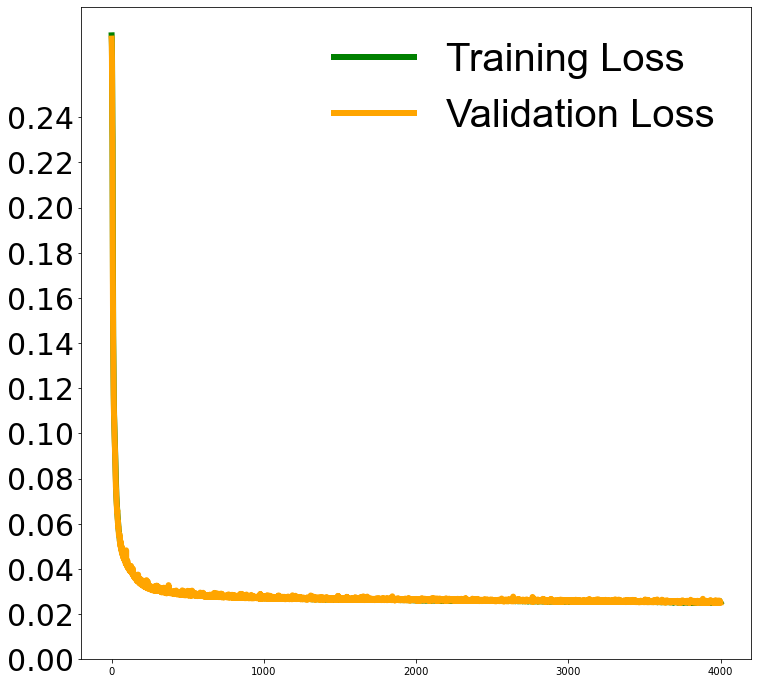

In [19]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D
loss = np.array(history.history['loss'])
valloss = np.array(history.history['val_loss'])
fig = plt.figure(figsize = (12,12))
# ax = fig.add_subplot(111, projection='3d')
epoch = np.arange(4000)
plt.plot(epoch, loss, c = 'g', label = 'Training Loss', linewidth = 6)
plt.plot(epoch, valloss, c = 'orange', label = 'Validation Loss', linewidth = 6)
plt.yticks(np.arange(0, 0.26, 0.02), fontsize = 30)
# plt.xticks(np.arange(1000), fontsize = 30)

font = {'family' : 'Arial',
        'size'   : 40}
fig.draw(fig.canvas.get_renderer())
plt.rc('font', **font)
plt.legend(frameon=False)
# plt.savefig('C:/Users/qoqud/Graph_loss.png')
plt.show()

In [20]:
model.save_weights('./model_weights_combination_inferenced_both_FSNN_Small_2')

# Test

0.01968292072694573 28.844528247158962 1.8686407608123874


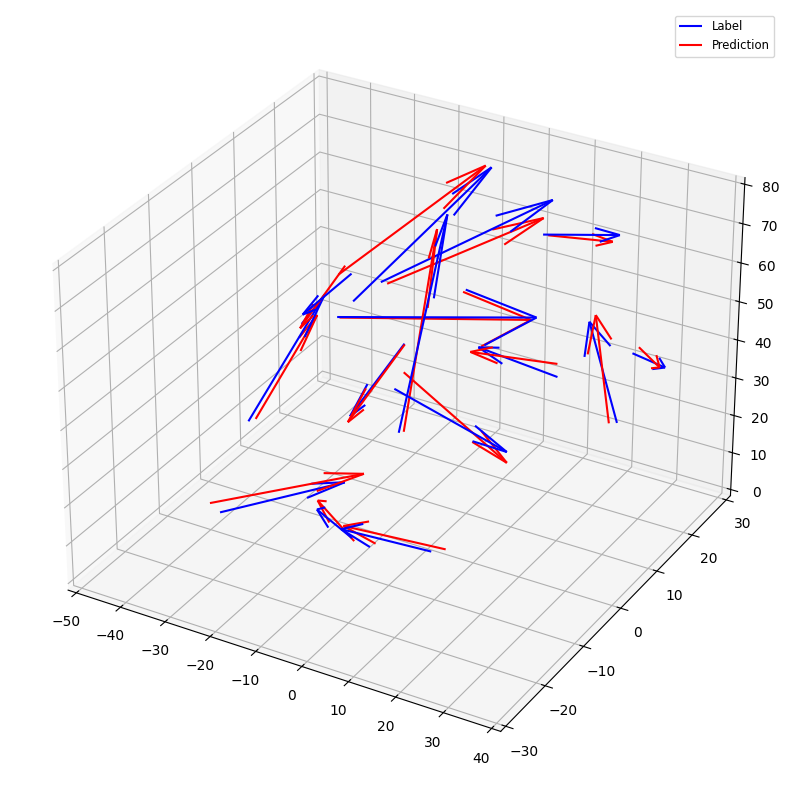

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D
model2 = OurModel()
model2.load_weights('./model_weights_combination_inferenced_both_FSNN_Small_2')
test_predict_scaled = model2.predict(test_data)
diff_scaled = test_predict_scaled - test_label_scaled
mae_scaled = np.mean(abs(diff_scaled))

test_predict = scaler.inverse_transform(test_predict_scaled)
diff = test_predict - test_label_scaled
mae_f = np.mean(abs(diff))

test_predict_speed = test_predict[:,3:] - test_predict[:,:3]
test_label_speed = test_label[:,3:] - test_label[:,:3]
diff_speed= test_predict_speed - test_label_speed
mae_speed = np.mean(abs(diff_speed))

print(mae_scaled, mae_f, mae_speed)

import matplotlib.pyplot as plt
N = 40
M= 55
plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.set_xlim3d(-50, 40)
ax.set_ylim3d(-30, 30)
ax.set_zlim3d(0, 80)

for i in range(N,M):
    ax.quiver(test_data_original_position[i][0],test_data_original_position[i][1],test_data_original_position[i][2], 
              test_label_speed[i][0], test_label_speed[i][1], test_label_speed[i][2], 
              length=1.0,
              color='b',
              label='Label')
    ax.quiver(test_predict[i][0],test_predict[i][1],test_predict[i][2], 
              test_predict_speed[i][0], test_predict_speed[i][1], test_predict_speed[i][2], 
              length=1.0,
              color='r',
              label='Prediction')
plt.legend(["Label", "Prediction"], fontsize="small")
plt.show()

In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
float_tflite_model = converter.convert()
float_tflite_model_size = open('float_split_conv_model_maxpool_6'+ '.tflite', "wb").write(float_tflite_model)
c_model_name_2 = 'float_split_conv_model_maxpool_6'   

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.target_spec.supported_types = [tf.int8]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
def representative_dataset_gen():
    for i in range(100):
        data = train_data[i,:,:,:]
        
        a,b,c = data.shape
        flattened_data = np.array(data.flatten(), dtype=np.float32).reshape(1, a, b, c)
        
        yield [flattened_data]

converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()
#tflite_model_name = 'int8_split_conv_model_inference_5'  # Will be given .tflite suffix
c_model_name = 'int8_split_conv_model_inference_6'

tflite_model_size = open(c_model_name + '.tflite', 'wb').write(tflite_model)
print("Quantized model is %d bytes" % tflite_model_size)

INFO:tensorflow:Assets written to: C:\Users\qoqud\AppData\Local\Temp\tmp859td2nr\assets
INFO:tensorflow:Assets written to: C:\Users\qoqud\AppData\Local\Temp\tmp4cvexjgk\assets


INFO:tensorflow:Assets written to: C:\Users\qoqud\AppData\Local\Temp\tmp4cvexjgk\assets


Quantized model is 11992 bytes


In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_model_name = 'split_conv_model_maxpool_0913'  # Will be given .tflite suffix
c_model_name = 'split_conv_model_maxpool_0913'   

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\qoqud\AppData\Local\Temp\tmpomu3fren\assets


INFO:tensorflow:Assets written to: C:\Users\qoqud\AppData\Local\Temp\tmpomu3fren\assets


26664

In [14]:
import binascii

def convert_to_c_array(bytes) -> str:
  hexstr = binascii.hexlify(bytes).decode("UTF-8")
  hexstr = hexstr.upper()
  array = ["0x" + hexstr[i:i + 2] for i in range(0, len(hexstr), 2)]
  array = [array[i:i+10] for i in range(0, len(array), 10)]
  return ",\n  ".join([", ".join(e) for e in array])

tflite_binary = open(c_model_name+ '.tflite', 'rb').read()
ascii_bytes = convert_to_c_array(tflite_binary)
header_file = "const unsigned char model_tflite[] = {\n  " + ascii_bytes + "\n};\nunsigned int model_tflite_len = " + str(len(tflite_binary)) + ";"
# print(c_file)
open(c_model_name+ '.h', "w").write(header_file)

74431

In [10]:
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [11]:
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))